## Import tools

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

## Node class

In [2]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None): 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

## Tree class

In [3]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0): 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            #print("INFO_GAIN: " + str(best_split["info_gain"]))
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "etc")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        elif mode=="etc":
            gain = self.nsrps(parent,2) - (weight_l*self.nsrps(l_child,2) + weight_r*self.nsrps(r_child,2))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def checkhomogenous(self, arr):
        n = len(arr)
        if n == 0:
            return True
        cur = arr[0]
        for num in arr:
            if num != cur:
                return False
        return True
    
    def nsrps(self, arr, k):
        if self.checkhomogenous(arr):
            return 0

        n = len(arr)
        freq = {}
        mxnum = max(arr)
        mxfreq = 0
        mxtup = ()
        for i in range(n - k + 1):
            cur = tuple(arr[i:i+k])
            if cur in freq:
                freq[cur] += 1
            else:
                freq[cur] = 1
            if(freq[cur] > mxfreq):
                mxfreq = freq[cur]
                mxtup = cur

        narr = []
        i = 0
        while (i < n):
            cur = tuple(arr[i:i+k])
            if(cur == mxtup):
                narr.append(mxnum + 1)
                i = i + k
            else:
                narr.append(arr[i])
                i += 1
        return 1 + self.nsrps(narr, k)
    
    def entropy(self, y):
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Toy Example Data

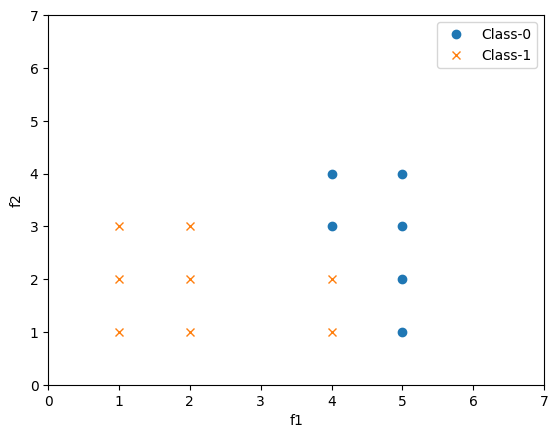

In [4]:
x1=[1,1,1,2,2,2,4,4]
y1=[1,2,3,1,2,3,1,2]
x0=[4,4,5,5,5,5]
y0=[3,4,3,4,1,2]
plt.plot(x0,y0,marker='o',linestyle="None",label="Class-0")
plt.plot(x1,y1,marker='x',linestyle="None",label="Class-1")
plt.xticks(range(8))
plt.yticks(range(8))
plt.xlabel("f1")
plt.ylabel("f2")
plt.legend()
plt.show()
# plotting the original dataset

In [5]:
f1=[1,1,1,2,2,2,4,4,4,4,5,5,5,5]
# list of feature 1

In [6]:
f2=[1,2,3,1,2,3,1,2,3,4,1,2,3,4]
# list of feature 2

In [7]:
cl=[1,1,1,1,1,1,1,1,0,0,0,0,0,0]
# list of target values/classes

In [8]:
names=["f1","f2"]

In [9]:
df1=pd.DataFrame(f1)
df2=pd.DataFrame(f2)
df3=pd.DataFrame(cl)

In [10]:
tempdf=pd.concat([df1,df2,df3],axis=1,ignore_index=True)
# creating a dataframe to represent complete dataset

In [11]:
data=pd.concat([df1,df2],axis=1,ignore_index=True)
labels=df3
#creating separtate dataframes for data and labels

In [12]:
data = data.rename({0: names[0],1: names[1]}, axis=1)
labels = labels.rename({0: "Target"}, axis=1)
# naming columns in respective dataframes

In [13]:
permorder = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
df=pd.DataFrame(columns=range(tempdf.shape[1]))
for i in permorder:
    l=list(tempdf.iloc[i-1])
    df.loc[len(df.index)]=l

In [14]:
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy().reshape(-1,1)

## AutoRegressive Data

In [27]:
N = 1000 # number of rows
M = 10 # number of columns

C1 = [0.9,0.1,0.8,0.2,0.7,0.3,0.6,0.4,0.5,0.15]
B1 = C1[::-1]
B2 = 0.6

cause = [[0 for col in range(M)] for row in range(N)]
effect = [[0 for col in range(M)] for row in range(N)]

for row in range(N):
    for col in range(M):
        if row == 0:
            cause[row][col] = np.random.normal(0,0.33)
        else:
            cause[row][col] = C1[col] * cause[row - 1][col] + np.random.normal(0,0.33)

for row in range(N):
    for col in range(M):
        if row == 0:
            effect[row][col] = np.random.normal(0,0.33)
        else:
            effect[row][col] = B1[col] * effect[row - 1][col] + B2 * cause[row - 1][col] + np.random.normal(0,0.33)
    
# Removing Transient data
cause = np.array(cause)
cause = cause[100:,:]
effect = np.array(effect)
effect = effect[100:,:]
X_vals = np.zeros((400,M))
Y_vals = np.zeros((400,1),dtype='int64')

# cause
for i in range(200):
    X_vals[i] = cause[i]
    Y_vals[i] = 0
# effect
for i in range(200):
    X_vals[200+i] = effect[i]
    Y_vals[200+i] = 1
Y_vals

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [28]:
tss = TimeSeriesSplit(n_splits = 10)
count = 0
for train_index, test_index in tss.split(X_vals):
    count+=1
    x_train, x_test = X_vals[train_index, :], X_vals[test_index,:]
    y_train, y_test = Y_vals[train_index], Y_vals[test_index]
    classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=11)
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test) 
    print("Accuracy in Split ",count," : ", accuracy_score(y_test, y_pred)*100)

Accuracy in Split  1  :  100.0
Accuracy in Split  2  :  100.0
Accuracy in Split  3  :  100.0
Accuracy in Split  4  :  100.0
Accuracy in Split  5  :  44.44444444444444
Accuracy in Split  6  :  16.666666666666664
Accuracy in Split  7  :  27.77777777777778
Accuracy in Split  8  :  22.22222222222222
Accuracy in Split  9  :  41.66666666666667
Accuracy in Split  10  :  55.55555555555556


## Fit the model

In [ ]:
print(Y.shape)
X_vals

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=20)
classifier.fit(X_vals,Y_vals)
classifier.print_tree()